# CNN With Self-Attention

## Necessary imports

In [8]:
import torch
from torch import nn
import torch.nn.functional as F
from typing import Callable
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from torchvision import datasets, transforms


## Self-Attention Layer

In [9]:
# input shape [batch_size, channel, width, hieght]
class SelfAttentionLayer(nn.Module):
    def __init__(self, in_planes, out_planes, head, similarity_fun: Callable[[torch.tensor], torch.tensor]) -> None:
        super().__init__()
        self.qurey = nn.Conv2d(in_planes, out_planes, kernel_size=1)
        self.key = nn.Conv2d(in_planes, out_planes, kernel_size=1)
        self.value = nn.Conv2d(in_planes, out_planes, kernel_size=1)
        self.similarity_fun = similarity_fun
        self.output = nn.Conv2d(out_planes, in_planes, kernel_size=1)
        self.gamma = nn.Parameter(torch.tensor([0.]))
        self.head = head
        self.out_dim = out_planes // self.head
    
    def forward(self, x):
        shape = x.shape
        batch_size, channels, width, height = shape
        # print("x", x.shape)
        q, k, v = self.qurey(x), self.key(x), self.value(x)        
        #For single head
        # q = q.view(*q.shape[:2], -1)
        # k = k.view(*k.shape[:2], -1)
        # v = v.view(*v.shape[:2], -1)

        #For multi head
        q = q.view(batch_size * self.head, self.out_dim, width * height)
        k = k.view(batch_size * self.head, self.out_dim, width * height)
        v = v.view(batch_size * self.head, self.out_dim, width * height)

        
        a = F.softmax(self.similarity_fun(q, k), dim=-1)

        # print('a', a.shape)
        # print('v', v.shape)
        channels = v.shape[1]
        #For single head
        # o = self.output(torch.bmm(a, v).view(batch_size, channels, width, height))
        #For multi head
        o = self.output(torch.bmm(a, v).view(batch_size, self.out_dim * self.head, width, height))
        # print('val',  o.shape)

        return self.gamma * o + x 


In [10]:
def similarity_fun(Q: torch.tensor, K: torch.tensor):
    return torch.bmm(Q, K.transpose(1, 2))/torch.sqrt(torch.tensor(K.shape[-1]))

## Model

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    

In [12]:
class CNNWithAttention(nn.Module):
    def __init__(self):
        super(CNNWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = ResidualBlock(16, 32, stride=2)
        self.att1 = SelfAttentionLayer(32, 64, 4, similarity_fun)  # Adjust parameters as necessary
        self.layer2 = ResidualBlock(32, 64, stride=2)
        self.att2 = SelfAttentionLayer(64, 128, 4, similarity_fun)  # Adjust parameters as necessary
        self.layer3 = ResidualBlock(64, 128, stride=2)
        self.gpa = nn.AdaptiveAvgPool2d((1, 1))
        self.finalFC = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.att1(x)  
        x = self.layer2(x)
        x = self.att2(x)  
        x = self.layer3(x)
        x = self.gpa(x)
        x = x.view(x.size(0), -1)
        x = self.finalFC(x)
        return x

## Data Loaders

In [13]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),

])


# For validation
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training dataset
trainset = datasets.CIFAR10(root='./', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

# Download and load the test dataset
testset = datasets.CIFAR10(root='./', train=False,
                                       download=True, transform=transform_val)
testloader = DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


## Model Initalization

In [14]:
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

model = CNNWithAttention().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

cuda


## Training Function

In [15]:
import os

def save_checkpoint(state, filename="model_checkpoint.tar"):
    os.makedirs(os.path.dirname(filename), exist_ok=True)  # Ensure directory exists
    torch.save(state, filename)

def load_checkpoint(checkpoint_path, model, optimizer, scheduler=None):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler is not None and 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return checkpoint.get('epoch', -1), checkpoint.get('best_accuracy', 0.0)

def train_and_validate(model, train_loader, test_loader, optimizer, criterion, device, scheduler=None, num_epochs=5, checkpoint_path=None, filename="checkpoints/model_checkpoint.tar"):
    start_epoch = 0
    best_accuracy = 0.0
    # Initialize lists to store per-epoch accuracies
    val_accuracies = []
    tra_loss = []
    val_loss = []
    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        start_epoch, best_accuracy = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
        print(f"Loaded checkpoint '{checkpoint_path}' (epoch {start_epoch}), best accuracy: {best_accuracy}%")
        start_epoch += 1  # Continue from next epoch

    for epoch in range(start_epoch, start_epoch + num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{start_epoch + num_epochs}', leave=False):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs + start_epoch}], Loss: {running_loss/len(train_loader):.4f}')
        tra_loss.append((epoch+1, running_loss/len(train_loader)))
        # Update the learning rate scheduler after each epoch
        if scheduler is not None:
            scheduler.step()

        # Validation loop
        model.eval()
        total = 0
        correct = 0
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc='Validating', leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()
        
        current_accuracy = 100 * correct / total
        print(f'Validation Accuracy: {current_accuracy:.2f}%')
        val_accuracies.append((epoch+1,current_accuracy))
        val_loss.append((epoch+1, running_loss/len(test_loader)))

        # Save checkpoint if current accuracy is the best
        if current_accuracy > best_accuracy:
            print("Saving new best model")
            best_accuracy = current_accuracy
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_accuracy': best_accuracy
            }
            if scheduler is not None:
                checkpoint['scheduler_state_dict'] = scheduler.state_dict()
            save_checkpoint(checkpoint, filename=filename)

    return val_accuracies, tra_loss, val_loss


## Training 

In [16]:
#File Path for the checkpoint which we are using to save the model state
filepath = "checkpoints\cnn\cnn_MAT__lr_0_001_op_adam_dataA_N_Tes.tar"

In [17]:
cnn_val_acc, cnn_tra_loss, cnn_val_loss = train_and_validate(model, trainloader, testloader, optimizer, criterion, device, scheduler, num_epochs=10, checkpoint_path=filepath, filename=filepath)

Epoch [1/10], Loss: 1.5853


Validation Accuracy: 55.24%
Saving new best model


Epoch [2/10], Loss: 1.2181


Validation Accuracy: 63.19%
Saving new best model


Epoch [3/10], Loss: 1.0698


Validation Accuracy: 64.63%
Saving new best model


Epoch [4/10], Loss: 0.9677


Validation Accuracy: 69.67%
Saving new best model


Epoch [5/10], Loss: 0.8936


Validation Accuracy: 69.18%


Epoch [6/10], Loss: 0.8397


Validation Accuracy: 74.49%
Saving new best model


Epoch [7/10], Loss: 0.7929


Validation Accuracy: 74.81%
Saving new best model


Epoch [8/10], Loss: 0.7559


Validation Accuracy: 74.79%


Epoch [9/10], Loss: 0.7302


Validation Accuracy: 77.52%
Saving new best model


Epoch [10/10], Loss: 0.6974


Validation Accuracy: 77.46%


## Display Image with there Prediction And Ground Truth

In [18]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_predictions(model, device, dataloader, classes, num_images=5):
    model.eval()  # Ensure the model is in evaluation mode
    
    # Detect if we have a GPU available
    
    model.to(device)  # Ensure the model is on the correct device

    # Fetch a batch of images
    images, labels = next(iter(dataloader))
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)  # Transfer to the same device

    # Get predictions
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Move images back to CPU for visualization
    images = images.to('cpu')
    labels = labels.to('cpu')
    predicted = predicted.to('cpu')

    # Display images
    imshow(torchvision.utils.make_grid(images))
    
    # Print actual and predicted labels
    print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(num_images)))
    print('Predicted: ', ' '.join(f'{classes[predicted[j]]}' for j in range(num_images)))


# Define the CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


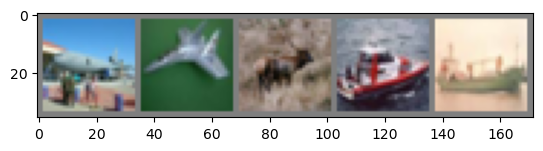

GroundTruth:  plane plane deer ship ship
Predicted:  plane plane deer ship ship


In [19]:
testloaderPre = DataLoader(testset, batch_size=128,
                                         shuffle=True, num_workers=2)
modelPre =  CNNWithAttention().to(device)
load_checkpoint("checkpoints\cnn\cnn_MAT__lr_0_001_op_adam_dataA.tar", modelPre, optimizer)
show_predictions(modelPre, device, testloaderPre, classes, num_images=5)

# Vision Transformer

## Self-Attention Layer

In [20]:
class SelfAttentionLayerTransformer(nn.Module):
    def __init__(self, in_dim, out_dim, heads):
        super().__init__()
        self.query = nn.Linear(in_dim, out_dim)
        self.key = nn.Linear(in_dim, out_dim)
        self.value = nn.Linear(in_dim, out_dim)
        self.heads = heads
        self.out_dim_per_head = out_dim // heads
        self.output = nn.Linear(out_dim, in_dim)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        q = self.query(x).view(batch_size, seq_len, self.heads, self.out_dim_per_head).transpose(1, 2)
        k = self.key(x).view(batch_size, seq_len, self.heads, self.out_dim_per_head).transpose(1, 2)
        v = self.value(x).view(batch_size, seq_len, self.heads, self.out_dim_per_head).transpose(1, 2)
        
        # Calculate the attention scores
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.out_dim_per_head, dtype=torch.float32))
        attention = torch.softmax(attention_scores, dim=-1)
        
        # Apply attention to the values
        out = torch.matmul(attention, v)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        out = self.output(out)
        
        return self.gamma * out + x


## Position Embedding Layer

In [21]:
# Assuming input shape (batch_size, n_patches, C * patch_size * patch_size)
class AddPositionEmbedding(nn.Module):
    def __init__(self, num_patches, emb_dim) -> None:
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))  # +1 for class token

    def forward(self, x):
        return x + self.pos_embedding


## MLP Layer

In [22]:
class MlpLayer(nn.Module):
    def __init__(self, input_dim, mlp_dim, dropout=0.5) -> None:
        super().__init__()
        self.layer1 = nn.Linear(input_dim, mlp_dim)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.layer2 = nn.Linear(mlp_dim, input_dim)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.gelu(self.layer1(x))
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.dropout2(x)
        return x

## Encoder Block
Architecture for encoder block

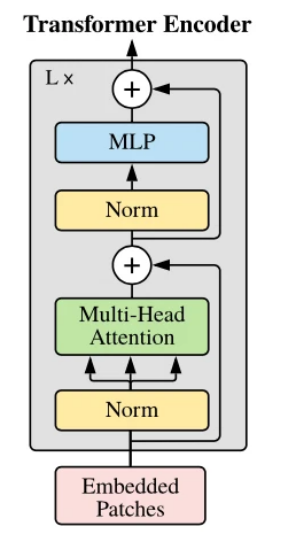

In [23]:
class Encoder(nn.Module):
    def __init__(self, input_dim, patch_size, att_dim, head, mlp_dim, num_patches, dropout=0.5) -> None:
        super().__init__()
        self.ln1 = nn.LayerNorm(input_dim)
        # Adjust the SelfAttentionLayer initialization if needed
        self.att = SelfAttentionLayerTransformer(input_dim, att_dim, head)
        self.ln2 = nn.LayerNorm(att_dim)
        self.mlp = MlpLayer(input_dim, mlp_dim, dropout)

    def forward(self, x):
        x = self.ln1(x)
        x_skip = x
        x = self.att(x)
        # Add the skip connection (residual)
        x = x + x_skip
        x = self.ln2(x)
        x_skip = x
        x = self.mlp(x)
        x = x + x_skip
        
        return x


## Transformer
With multiple blocks of Encoder

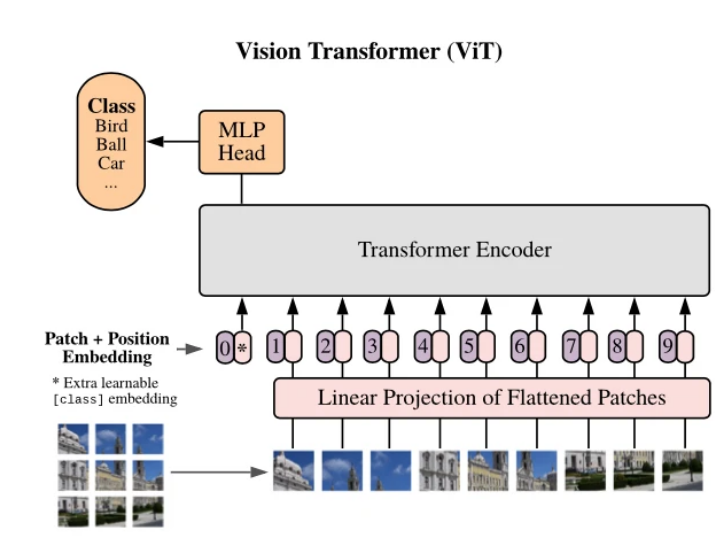

In [24]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, num_channels, num_classes, emb_dim, num_heads, mlp_dim, num_layers, dropout_rate=0.5):
        super().__init__()
        num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.emb_dim = emb_dim
        self.flatten_dim = patch_size * patch_size * num_channels
        self.linear_proj = nn.Linear(self.flatten_dim, emb_dim)
        self.class_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = AddPositionEmbedding(num_patches, emb_dim)

        self.layers = nn.ModuleList([
            Encoder(input_dim=emb_dim, patch_size=patch_size, att_dim=emb_dim, head=num_heads, mlp_dim=mlp_dim, num_patches=num_patches, dropout=dropout_rate)
            for _ in range(num_layers)
        ])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, num_classes)
        )

    def forward(self, x):
        # Unfold patches
        x = x.unfold(2, self.patch_size, self.patch_size) \
            .unfold(3, self.patch_size, self.patch_size)
        # Reshape: [Batch, Channels, Patch_height, Patch_width, Num_patches_height, Num_patches_width]
        x = x.permute(0, 4, 5, 1, 2, 3)
        # Flatten patches
        x = x.contiguous().view(x.size(0), -1, self.flatten_dim) # -1 here automatically calculates the correct number of patches
        x = self.linear_proj(x)

        # Add class token and position embeddings
        class_tokens = self.class_token.expand(x.size(0), -1, -1)
        x = torch.cat((class_tokens, x), dim=1)
        x = self.pos_embedding(x)

        # Process through the layers
        for layer in self.layers:
            x = layer(x)

        # Classifier token
        x = x[:, 0]
        x = self.mlp_head(x)
        return x



## Data Loading

In [25]:

from torchvision import transforms


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)  # Random erasing
])

# For validation
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = datasets.CIFAR10(root='./', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./', train=False, download=True, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


## Model Initialization

In [26]:
import torch.optim.lr_scheduler as lr_scheduler

model = VisionTransformer(
    img_size=32,  
    patch_size=4, 
    num_channels=3,
    num_classes=10,
    emb_dim=256,  
    num_heads=8,  
    mlp_dim=512, 
    num_layers=1,
    dropout_rate=0.1 
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Adjust the optimizer and learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)


# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


criterion = nn.CrossEntropyLoss()

print(device)

cuda


## Training

In [27]:
filepath = "checkpoints/transformer/vit_layer_1_lr_0_001_op_adam_TN.tar"
vit_val_acc, vit_tra_loss, vit_val_loss = train_and_validate(model, train_loader, test_loader, optimizer, criterion, device, scheduler, num_epochs=10, checkpoint_path=filepath, filename=filepath)

Epoch [1/10], Loss: 2.0564


Validation Accuracy: 29.39%
Saving new best model


Epoch [2/10], Loss: 1.9553


Validation Accuracy: 33.35%
Saving new best model


Epoch [3/10], Loss: 1.9210


Validation Accuracy: 35.92%
Saving new best model


Epoch [4/10], Loss: 1.8887


Validation Accuracy: 35.53%


Epoch [5/10], Loss: 1.8693


Validation Accuracy: 37.37%
Saving new best model


Epoch [6/10], Loss: 1.8521


Validation Accuracy: 38.89%
Saving new best model


Epoch [7/10], Loss: 1.8386


Validation Accuracy: 37.88%


Epoch [8/10], Loss: 1.8248


Validation Accuracy: 39.53%
Saving new best model


Epoch [9/10], Loss: 1.8110


Validation Accuracy: 39.88%
Saving new best model


Epoch [10/10], Loss: 1.7964


Validation Accuracy: 40.80%
Saving new best model


## Display Image with there Prediction And Ground Truth

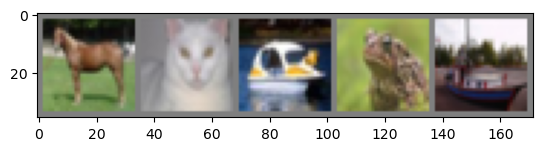

GroundTruth:  horse cat ship frog ship
Predicted:  horse dog dog bird plane


In [28]:
testloaderPre = DataLoader(testset, batch_size=64,
                                         shuffle=True, num_workers=2)
modelPre =  model = VisionTransformer(
    img_size=32,  
    patch_size=4, 
    num_channels=3,
    num_classes=10,
    emb_dim=256,  
    num_heads=8,  
    mlp_dim=512, 
    num_layers=1,
    dropout_rate=0.1 
).to(device)
load_checkpoint("checkpoints/transformer/vit_layer_1_lr_0_001_op_adam.tar", modelPre, optimizer)
show_predictions(modelPre, device, testloaderPre, classes, num_images=5)

# Ploting Code

In [29]:
def plot_validation_accuracies(cnn_val_acc, vit_val_acc):
    epochs_cnn = [x[0] for x in cnn_val_acc]
    acc_cnn = [x[1] for x in cnn_val_acc]
    
    epochs_vit = [x[0] for x in vit_val_acc]
    acc_vit = [x[1] for x in vit_val_acc]
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_cnn, acc_cnn, label='CNN with Self-Attention Validation Accuracy', marker='o')
    plt.plot(epochs_vit, acc_vit, label='Vision Transformer Validation Accuracy', marker='x')
    plt.title('Validation Accuracy: CNN vs. Vision Transformer')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()



def plot_losses(cnn_tra_loss, cnn_val_loss, vit_tra_loss, vit_val_loss):
    epochs_cnn = [x[0] for x in cnn_tra_loss]
    tra_loss_cnn = [x[1] for x in cnn_tra_loss]
    val_loss_cnn = [x[1] for x in cnn_val_loss]
    
    epochs_vit = [x[0] for x in vit_tra_loss]
    tra_loss_vit = [x[1] for x in vit_tra_loss]
    val_loss_vit = [x[1] for x in vit_val_loss]
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_cnn, tra_loss_cnn, 'r-', label='CNN Training Loss', marker='o')
    plt.plot(epochs_cnn, val_loss_cnn, 'r--', label='CNN Validation Loss', marker='o')
    plt.plot(epochs_vit, tra_loss_vit, 'b-', label='Vision Transformer Training Loss', marker='x')
    plt.plot(epochs_vit, val_loss_vit, 'b--', label='Vision Transformer Validation Loss', marker='x')
    plt.title('Training and Validation Loss: CNN vs. Vision Transformer')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


# CNN vs. Transformer Performance

The effectiveness of Convolutional Neural Networks (CNNs) is generally superior to that of transformers. This difference in performance is primarily due to the necessity for transformers to be trained on a significantly larger dataset to match the accuracy levels of CNNs.

### State of the Art Results

It should be noted that the state-of-the-art results discussed in the referenced paper https://arxiv.org/pdf/2010.11929.pdf are achieved through a specific methodology. This involves initially pre-training the Vision Transformer (ViT) model on the JFT-300M dataset. Following this pre-training phase, the model is fine-tuned on the designated dataset to achieve the reported results.


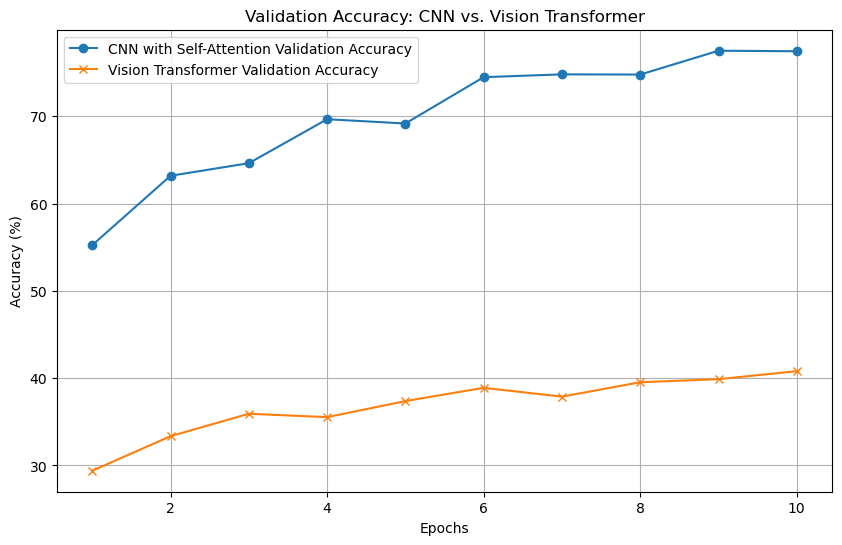

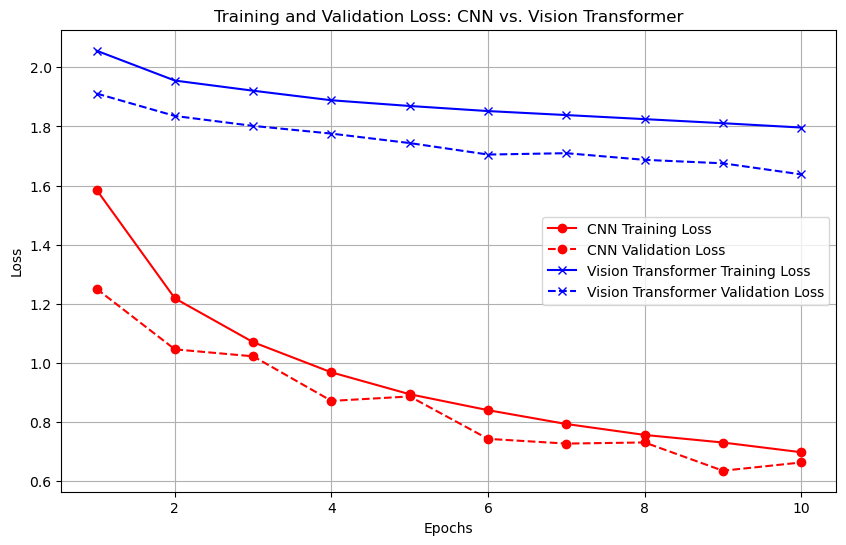

In [30]:
# Plot Validation Accuracies
plot_validation_accuracies(cnn_val_acc, vit_val_acc)

# Plot Training and Validation Losses
plot_losses(cnn_tra_loss, cnn_val_loss, vit_tra_loss, vit_val_loss)


### Description of the Plots

The horizontal lines in the graphs indicate that the data points for each epoch are consistent, reflecting the information recorded at the last epoch saved by the checkpoints for both models. Consequently, the plots demonstrate only the final epoch's data for the training and validation losses, as well as the validation accuracies for the CNN with Self-Attention and the Vision Transformer models. The lack of variation across epochs is because the data for previous epochs was not recorded prior to the saving of these checkpoints.

### Note
If the code is executed with a newly initialized model, the expected fluctuations and trends typically observed in training and validation loss, as well as accuracy metrics over multiple epochs, will be evident in the graphs. The current static representation is a result of the checkpoint-based data retrieval which only captured the final epoch's metrics.
